In [1]:
# =============================================================================
# NOTEBOOK 4: EXPERIMENTO 2 - ANÁLISIS DE CONTEXTO (MAX_LEN)
# =============================================================================

import os
import pickle
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración básica
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "data_processed"
MODELS_DIR = "models"   # se reutiliza la misma carpeta

os.makedirs(MODELS_DIR, exist_ok=True)

print(f"Usando dispositivo: {DEVICE}")

# Longitudes a evaluar
MAX_LEN_LIST = [20, 40, 60]

# Cuántos modelos guardar por cada MAX_LEN (top-K)
SAVE_TOP_K = 3

# Semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Usando dispositivo: cuda


In [2]:
# =============================================================================
# CELDA 2: CARGA DE DATOS Y VOCABULARIO
# =============================================================================

# Cargar vocabulario y splits creados en Notebook 1
vocab = pickle.load(open(f"{DATA_DIR}/vocab.pkl", "rb"))
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
val_df = pd.read_csv(f"{DATA_DIR}/val.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

PAD_IDX = vocab["<PAD>"]
UNK_IDX = vocab["<UNK>"]

print("Tamaños de los datasets:")
print(f"Train: {len(train_df)}")
print(f"Val:   {len(val_df)}")
print(f"Test:  {len(test_df)}")
print(f"Tamaño vocabulario: {len(vocab)}")


Tamaños de los datasets:
Train: 6675
Val:   1430
Test:  1432
Tamaño vocabulario: 6295


In [3]:
# =============================================================================
# CELDA 3: DATASET Y COLLATE CON MAX_LEN VARIABLE
# =============================================================================

def basic_tokenize(text):
    return str(text).lower().split()

def encode_text(text, vocab):
    tokens = basic_tokenize(text)
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens]
    return torch.tensor(ids, dtype=torch.long)

class FinancialTweetsDataset(Dataset):
    def __init__(self, df, vocab):
        self.df = df
        self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]["text"]
        label = int(self.df.iloc[idx]["label"])
        encoded = encode_text(text, self.vocab)
        return encoded, label

def make_collate_fn(max_len, pad_idx):
    """Crea una función collate que recorta/paddea a max_len."""
    def collate_fn(batch):
        texts, labels = zip(*batch)
        lengths = [len(t) for t in texts]
        max_batch_len = min(max_len, max(lengths))

        padded = []
        for seq in texts:
            seq = seq[:max_batch_len]
            if len(seq) < max_batch_len:
                seq = torch.cat([seq, torch.tensor([pad_idx] * (max_batch_len - len(seq)))])
            padded.append(seq)

        padded = torch.stack(padded)
        labels_t = torch.tensor(labels, dtype=torch.long)
        lengths_t = torch.tensor([min(l, max_batch_len) for l in lengths], dtype=torch.long)

        return padded, labels_t, lengths_t
    return collate_fn

# Instanciar datasets (compartidos para todos los MAX_LEN)
train_ds = FinancialTweetsDataset(train_df, vocab)
val_ds   = FinancialTweetsDataset(val_df, vocab)
test_ds  = FinancialTweetsDataset(test_df, vocab)

print("Datasets creados correctamente.")


Datasets creados correctamente.


In [5]:
# =============================================================================
# CELDA 4: DEFINICIÓN DE MODELOS (IGUAL A NOTEBOOK 2)
# =============================================================================

class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_output, mask):
        # rnn_output: (batch, seq, hidden)
        scores = self.attn(rnn_output).squeeze(-1)        # (batch, seq)
        scores = scores.masked_fill(mask == 0, -1e9)      # Padding → -inf
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(rnn_output * attn_weights.unsqueeze(-1), dim=1)
        return context

class RecurrentClassifier(nn.Module):
    def __init__(self, model_type, vocab_size, embed_dim, hidden_dim, out_dim,
                 n_layers, dropout, pad_idx, bidirectional=False, use_attention=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.model_type = model_type
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        if model_type == 'lstm':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers,
                               batch_first=True,
                               dropout=dropout if n_layers > 1 else 0,
                               bidirectional=bidirectional)
        else:
            self.rnn = nn.GRU(embed_dim, hidden_dim, n_layers,
                              batch_first=True,
                              dropout=dropout if n_layers > 1 else 0,
                              bidirectional=bidirectional)
        
        self.rnn_out_dim = hidden_dim * (2 if bidirectional else 1)
        
        if use_attention:
            self.attention = AttentionPooling(self.rnn_out_dim)
        else:
            self.attention = None
            
        self.fc = nn.Linear(self.rnn_out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx

    def forward(self, x, lengths=None):
        mask = (x != self.pad_idx).float()
        emb = self.embedding(x)
        
        if self.model_type == 'lstm':
            rnn_out, (h_n, c_n) = self.rnn(emb)
        else:
            rnn_out, h_n = self.rnn(emb)
            
        if self.use_attention:
            context = self.attention(rnn_out, mask)
        else:
            if self.bidirectional:
                # h_n: (num_layers * num_directions, batch, hidden)
                h_last = h_n.view(self.n_layers, 2, x.size(0), self.hidden_dim)[-1]
                context = torch.cat([h_last[0], h_last[1]], dim=1)
            else:
                context = h_n[-1]
                
        logits = self.fc(self.dropout(context))
        return logits


In [6]:
# =============================================================================
# CELDA 5: ENTRENAMIENTO, EVALUACIÓN Y MÉTRICAS
# =============================================================================

BATCH_SIZE = 64
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
N_LAYERS = 2
DROPOUT = 0.3
LR = 1e-3
EPOCHS = 12
CLIP = 1.0
PATIENCE = 3

# Pesos de clase (desbalance)
counts = train_df["label"].value_counts().sort_index()
weights = 1.0 / counts
weights = weights / weights.sum()
class_weights = torch.tensor(weights.values, dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Pesos de clase usados:", weights.values)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, count = 0, 0, 0

    for xb, yb, lengths in loader:
        xb, yb, lengths = xb.to(DEVICE), yb.to(DEVICE), lengths.to(DEVICE)

        optimizer.zero_grad()
        logits = model(xb, lengths)
        loss = criterion(logits, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        count += xb.size(0)

    return total_loss / count, correct / count

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, count = 0, 0, 0

    with torch.no_grad():
        for xb, yb, lengths in loader:
            xb, yb, lengths = xb.to(DEVICE), yb.to(DEVICE), lengths.to(DEVICE)
            logits = model(xb, lengths)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            count += xb.size(0)

    return total_loss / count, correct / count

def eval_full_metrics(model, loader):
    """Devuelve accuracy, macro_f1 y f1 por clase en un loader dado."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb, lengths in loader:
            xb, yb, lengths = xb.to(DEVICE), yb.to(DEVICE), lengths.to(DEVICE)
            logits = model(xb, lengths)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(
        all_labels, all_preds,
        target_names=["Bajista", "Alcista", "Neutral"],
        output_dict=True,
        zero_division=0
    )

    macro_f1 = report["macro avg"]["f1-score"]
    f1_bajista = report["Bajista"]["f1-score"]
    f1_alcista = report["Alcista"]["f1-score"]
    f1_neutral = report["Neutral"]["f1-score"]

    return acc, macro_f1, f1_bajista, f1_alcista, f1_neutral


Pesos de clase usados: [0.50463279 0.37781801 0.11754921]


In [7]:
# =============================================================================
# CELDA 6: CONFIGURACIONES DE LOS 6 MODELOS
# =============================================================================

model_configs = [
    {'name': 'lstm_base',      'type': 'lstm', 'bi': False, 'attn': False},
    {'name': 'lstm_attn',      'type': 'lstm', 'bi': False, 'attn': True},
    {'name': 'gru_base',       'type': 'gru',  'bi': False, 'attn': False},
    {'name': 'gru_attn',       'type': 'gru',  'bi': False, 'attn': True},
    {'name': 'lstm_bi',        'type': 'lstm', 'bi': True,  'attn': False},
    {'name': 'lstm_bi_attn',   'type': 'lstm', 'bi': True,  'attn': True},
]

print("Modelos a evaluar en Experimento 2:")
for c in model_configs:
    print(f" - {c['name']} (type={c['type']}, bi={c['bi']}, attn={c['attn']})")


Modelos a evaluar en Experimento 2:
 - lstm_base (type=lstm, bi=False, attn=False)
 - lstm_attn (type=lstm, bi=False, attn=True)
 - gru_base (type=gru, bi=False, attn=False)
 - gru_attn (type=gru, bi=False, attn=True)
 - lstm_bi (type=lstm, bi=True, attn=False)
 - lstm_bi_attn (type=lstm, bi=True, attn=True)


In [8]:
# =============================================================================
# CELDA 7: LOOP PRINCIPAL DEL EXPERIMENTO 2
# Entrenar 6 modelos por cada MAX_LEN y guardar resultados
# =============================================================================

results = []  # aquí se guardarán las métricas para el CSV y gráficos
best_models_by_maxlen = {}  # para evaluaciones cualitativas
all_saved_models = []       # para guardar top-K por MAX_LEN

for max_len in MAX_LEN_LIST:
    print("\n" + "#"*70)
    print(f"#   ENTRENANDO MODELOS PARA MAX_LEN = {max_len}")
    print("#"*70)

    # DataLoaders para este MAX_LEN
    collate_fn = make_collate_fn(max_len, PAD_IDX)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Para elegir top-K por este MAX_LEN
    local_models_info = []

    for conf in model_configs:
        m_name = conf['name']
        m_type = conf['type']
        bi     = conf['bi']
        attn   = conf['attn']

        print(f"\n{'='*60}")
        print(f" Entrenando modelo: {m_name} (MAX_LEN={max_len})")
        print(f"{'='*60}")

        model = RecurrentClassifier(
            model_type=m_type,
            vocab_size=len(vocab),
            embed_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            out_dim=3,
            n_layers=N_LAYERS,
            dropout=DROPOUT,
            pad_idx=PAD_IDX,
            bidirectional=bi,
            use_attention=attn
        ).to(DEVICE)

        optimizer = optim.AdamW(model.parameters(), lr=LR)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

        best_val_acc = 0.0
        best_state_dict = None
        patience_counter = 0

        # Entrenamiento con early stopping
        for ep in range(EPOCHS):
            tl, ta = train_epoch(model, train_loader, optimizer, criterion)
            vl, va = eval_epoch(model, val_loader, criterion)
            scheduler.step()

            print(f"Epoch {ep+1:02d}/{EPOCHS} | "
                  f"T.Loss: {tl:.4f} Acc: {ta:.4f} | "
                  f"V.Loss: {vl:.4f} Acc: {va:.4f}")

            if va > best_val_acc:
                best_val_acc = va
                best_state_dict = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= PATIENCE:
                    print(f"--> Early stopping en época {ep+1}")
                    break

        # Restaurar mejores pesos antes de evaluar
        if best_state_dict is not None:
            model.load_state_dict(best_state_dict)

        # Métricas en validación
        val_acc, val_macro_f1, _, _, _ = eval_full_metrics(model, val_loader)

        # Métricas en test
        test_acc, test_macro_f1, f1_b, f1_a, f1_n = eval_full_metrics(model, test_loader)

        # Guardar resultado para tabla global
        results.append({
            "Model": m_name,
            "MAX_LEN": max_len,
            "Val_Acc": val_acc,
            "Val_Macro_F1": val_macro_f1,
            "Test_Acc": test_acc,
            "Test_Macro_F1": test_macro_f1,
            "Test_F1_Bajista": f1_b,
            "Test_F1_Alcista": f1_a,
            "Test_F1_Neutral": f1_n
        })

        # Guardar info local para luego elegir top-K
        local_models_info.append({
            "Model": m_name,
            "MAX_LEN": max_len,
            "Val_Macro_F1": val_macro_f1,
            "State_Dict": best_state_dict,
            "Config": {
                'model_type': m_type,
                'vocab_size': len(vocab),
                'embed_dim': EMBEDDING_DIM,
                'hidden_dim': HIDDEN_DIM,
                'n_layers': N_LAYERS,
                'dropout': DROPOUT,
                'pad_idx': PAD_IDX,
                'bidirectional': bi,
                'use_attention': attn,
                'max_len': max_len
            }
        })

    # Ordenar por Macro F1 de validación y guardar top-K pesos
    local_models_info.sort(key=lambda x: x["Val_Macro_F1"], reverse=True)
    best_models_by_maxlen[max_len] = local_models_info[0]  # mejor modelo para evaluación cualitativa

    print(f"\nMejores {SAVE_TOP_K} modelos para MAX_LEN = {max_len}:")
    for i, info in enumerate(local_models_info[:SAVE_TOP_K]):
        m_name = info["Model"]
        score  = info["Val_Macro_F1"]
        print(f"  Top {i+1}: {m_name} (Val_Macro_F1 = {score:.4f})")

        # Guardar en disco
        ckpt = {
            "model_state": info["State_Dict"],
            "config": info["Config"],
            "vocab": vocab
        }
        save_path = os.path.join(
            MODELS_DIR,
            f"{m_name}_len{max_len}_best_model.pth"
        )
        torch.save(ckpt, save_path)
        all_saved_models.append(save_path)
        print(f"    --> Guardado en: {save_path}")

print("\nExperimento 2 - Entrenamiento completado.")



######################################################################
#   ENTRENANDO MODELOS PARA MAX_LEN = 20
######################################################################

 Entrenando modelo: lstm_base (MAX_LEN=20)
Epoch 01/12 | T.Loss: 1.0695 Acc: 0.4740 | V.Loss: 1.0270 Acc: 0.6552
Epoch 02/12 | T.Loss: 0.9445 Acc: 0.6553 | V.Loss: 0.9613 Acc: 0.6552
Epoch 03/12 | T.Loss: 0.8243 Acc: 0.7125 | V.Loss: 0.9130 Acc: 0.6077
Epoch 04/12 | T.Loss: 0.6695 Acc: 0.7784 | V.Loss: 0.9078 Acc: 0.6692
Epoch 05/12 | T.Loss: 0.5749 Acc: 0.8204 | V.Loss: 1.0190 Acc: 0.7273
Epoch 06/12 | T.Loss: 0.5012 Acc: 0.8494 | V.Loss: 1.0041 Acc: 0.7189
Epoch 07/12 | T.Loss: 0.4153 Acc: 0.8834 | V.Loss: 1.0525 Acc: 0.7357
Epoch 08/12 | T.Loss: 0.3626 Acc: 0.8980 | V.Loss: 1.0616 Acc: 0.7378
Epoch 09/12 | T.Loss: 0.3276 Acc: 0.9115 | V.Loss: 1.0789 Acc: 0.7280
Epoch 10/12 | T.Loss: 0.2875 Acc: 0.9243 | V.Loss: 1.2426 Acc: 0.7455
Epoch 11/12 | T.Loss: 0.2619 Acc: 0.9315 | V.Loss: 1.2234 Acc: 0.7524
Ep


=== RESULTADOS EXPERIMENTO 2 (RESUMEN) ===
           Model  MAX_LEN   Val_Acc  Val_Macro_F1  Test_Acc  Test_Macro_F1  \
5   lstm_bi_attn       20  0.776923      0.687486  0.787011       0.704169   
4        lstm_bi       20  0.779720      0.688443  0.777933       0.694436   
3       gru_attn       20  0.725874      0.642651  0.753492       0.685532   
1      lstm_attn       20  0.744755      0.661862  0.752095       0.668560   
2       gru_base       20  0.763636      0.680785  0.750698       0.663372   
0      lstm_base       20  0.745455      0.647766  0.751397       0.662753   
11  lstm_bi_attn       40  0.774825      0.687960  0.794693       0.707932   
10       lstm_bi       40  0.764336      0.665880  0.775140       0.692498   
7      lstm_attn       40  0.755944      0.664128  0.775838       0.689586   
9       gru_attn       40  0.745455      0.644815  0.763268       0.673419   
8       gru_base       40  0.770629      0.686809  0.754190       0.666534   
6      lstm_base    

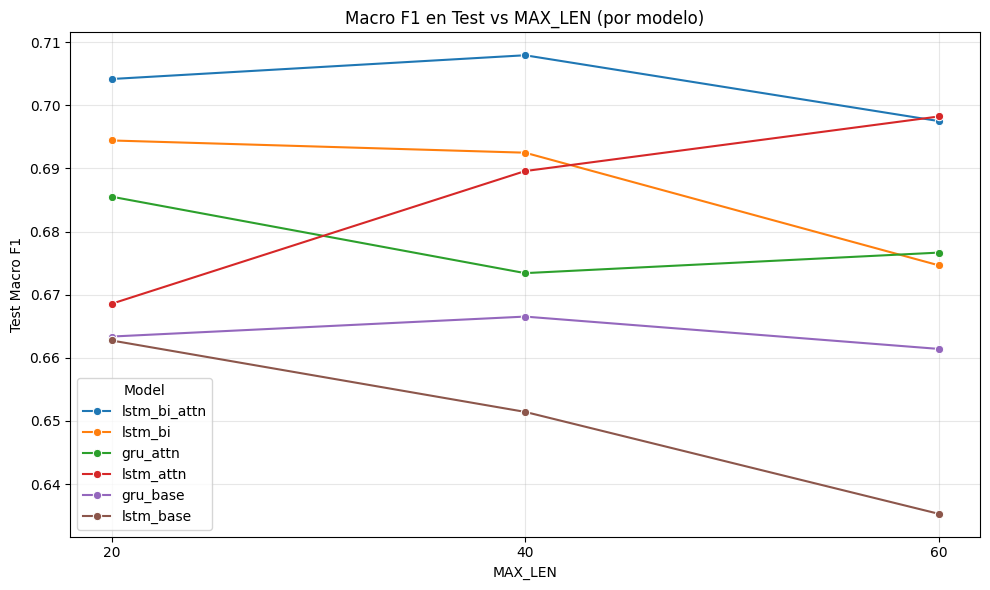

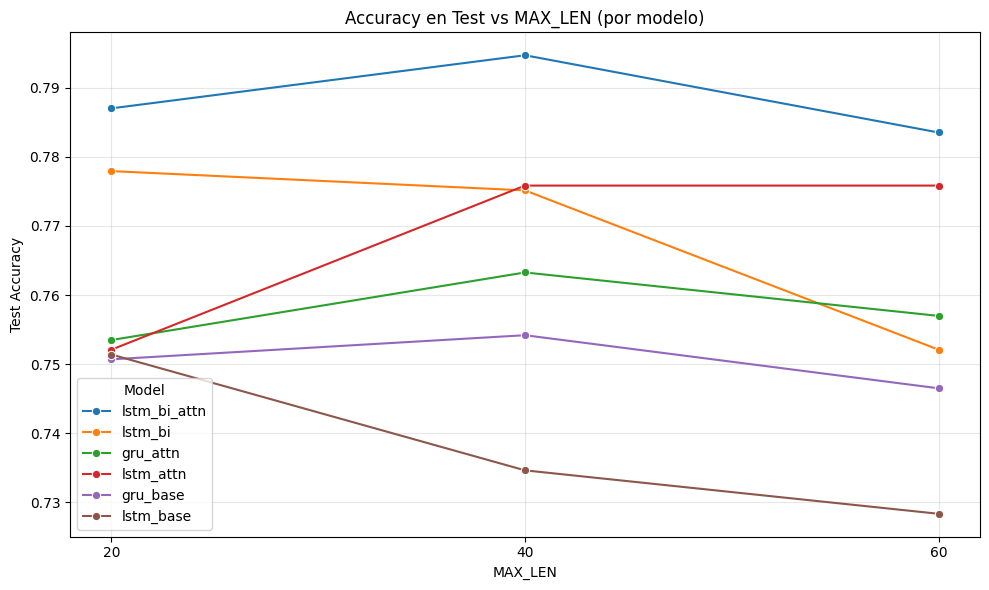

In [9]:
# =============================================================================
# CELDA 8: TABLAS Y GRÁFICOS COMPARATIVOS
# =============================================================================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["MAX_LEN", "Test_Macro_F1"], ascending=[True, False])

print("\n=== RESULTADOS EXPERIMENTO 2 (RESUMEN) ===")
print(results_df)

# Guardar CSV
csv_path = "experiment2_results.csv"
results_df.to_csv(csv_path, index=False)
print(f"\nResultados guardados en: {csv_path}")

# Gráfico Macro F1 vs MAX_LEN por modelo
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x="MAX_LEN", y="Test_Macro_F1",
    hue="Model", marker="o"
)
plt.title("Macro F1 en Test vs MAX_LEN (por modelo)")
plt.ylabel("Test Macro F1")
plt.xticks(MAX_LEN_LIST)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico Accuracy vs MAX_LEN por modelo
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x="MAX_LEN", y="Test_Acc",
    hue="Model", marker="o"
)
plt.title("Accuracy en Test vs MAX_LEN (por modelo)")
plt.ylabel("Test Accuracy")
plt.xticks(MAX_LEN_LIST)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# =============================================================================
# CELDA 9: EVALUACIÓN CUALITATIVA (SARCASMO, NEGACIONES, DEPENDENCIAS LARGAS)
# =============================================================================

ID2LABEL = {0: "Bajista", 1: "Alcista", 2: "Neutral"}

def predict_with_model(model, text, vocab, max_len):
    tokens = basic_tokenize(text)
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens]

    length = len(ids)
    length = min(length, max_len)
    ids = ids[:max_len]

    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))

    x = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([length], dtype=torch.long).to(DEVICE)

    model.eval()
    with torch.no_grad():
        logits = model(x, lengths)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))

    return ID2LABEL[pred_idx], probs

ejemplos = [
    # Sarcasmo
    "Amazing day in the market, we only lost 12 percent 🙃",
    "Yeah, great earnings... totally not disappointing at all",
    # Negaciones
    "This stock is not bad, I wouldn't sell yet",
    "I don't think this is a terrible report",
    # Dependencias largas
    "Although the morning session looked weak, the stock recovered strongly after the earnings call",
    "Despite the initial drop, positive guidance from the CEO pushed the price up at the end of the day"
]

print("\n" + "="*70)
print("EVALUACIÓN CUALITATIVA POR MAX_LEN (mejor modelo de cada MAX_LEN)")
print("="*70)

for max_len in MAX_LEN_LIST:
    info = best_models_by_maxlen[max_len]
    cfg = info["Config"]
    state_dict = info["State_Dict"]

    print(f"\n--- MAX_LEN = {max_len} | Mejor modelo: {info['Model']} ---")

    model = RecurrentClassifier(
        model_type=cfg["model_type"],
        vocab_size=cfg["vocab_size"],
        embed_dim=cfg["embed_dim"],
        hidden_dim=cfg["hidden_dim"],
        out_dim=3,
        n_layers=cfg["n_layers"],
        dropout=cfg["dropout"],
        pad_idx=cfg["pad_idx"],
        bidirectional=cfg["bidirectional"],
        use_attention=cfg["use_attention"]
    ).to(DEVICE)
    model.load_state_dict(state_dict)

    for txt in ejemplos:
        label, probs = predict_with_model(model, txt, vocab, max_len)
        print("\nTexto:", txt)
        print(f"Predicción (MAX_LEN={max_len}): {label}")
        print(f"Probabilidades -> Bajista: {probs[0]:.2f} | Alcista: {probs[1]:.2f} | Neutral: {probs[2]:.2f}")



EVALUACIÓN CUALITATIVA POR MAX_LEN (mejor modelo de cada MAX_LEN)

--- MAX_LEN = 20 | Mejor modelo: lstm_bi ---

Texto: Amazing day in the market, we only lost 12 percent 🙃
Predicción (MAX_LEN=20): Neutral
Probabilidades -> Bajista: 0.01 | Alcista: 0.01 | Neutral: 0.98

Texto: Yeah, great earnings... totally not disappointing at all
Predicción (MAX_LEN=20): Neutral
Probabilidades -> Bajista: 0.01 | Alcista: 0.00 | Neutral: 0.99

Texto: This stock is not bad, I wouldn't sell yet
Predicción (MAX_LEN=20): Neutral
Probabilidades -> Bajista: 0.00 | Alcista: 0.00 | Neutral: 1.00

Texto: I don't think this is a terrible report
Predicción (MAX_LEN=20): Neutral
Probabilidades -> Bajista: 0.00 | Alcista: 0.00 | Neutral: 1.00

Texto: Although the morning session looked weak, the stock recovered strongly after the earnings call
Predicción (MAX_LEN=20): Neutral
Probabilidades -> Bajista: 0.23 | Alcista: 0.06 | Neutral: 0.71

Texto: Despite the initial drop, positive guidance from the CEO pushed th